# Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import io
from PIL import Image

# Scikit-learn imports
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Signal processing imports
import pywt
import cv2
from scipy import signal
from scipy.stats import pearsonr

# PyTS image transforms
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

# PyTorch
import torch

# Plotly
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# **1. DATA LOADING AND PREPROCESSING**

In [ ]:
# 1. DATA LOADING AND PREPROCESSING
def load_data(file_path):
    """
    Load the dataset from a CSV file
    """
    df = pd.read_csv(file_path)
    print(f"Dataset loaded with shape: {df.shape}")
    return df

def preprocess_data(df):
    """
    Preprocess the raw dataframe:
    - Clean missing values
    - Extract relevant signals
    - Normalize features
    """
    # Make a copy to avoid modifying the original
    df_processed = df.copy()

    # Handle missing values
    df_processed = df_processed.dropna()

    # Extract relevant columns
    signal_columns = [col for col in df_processed.columns if any(x in col for x in
                      ['ECG', 'PPG', 'PPW'])]
    demographic_columns = ['age', 'gender', 'hight','weight', 'history of hypertension']
    bp_columns = ['dbppre', 'sbppre', 'dbppost', 'sbppost']

    # Convert categorical variables
    if 'gender' in df_processed.columns:
        df_processed['gender'] = df_processed['gender'].map({'1.0': 1, '0.0': 0, 1.0: 1, 0.0: 0})

    # Normalize signal data
    scaler = StandardScaler()
    df_processed[signal_columns] = scaler.fit_transform(df_processed[signal_columns])

    # Create feature matrix X and target vector y
    X = df_processed[signal_columns + demographic_columns]
    y = df_processed[['sbppre', 'dbppre']]  # Using pre-BP as targets

    return X, y, df_processed

def segment_signals(signal_data, window_size=256, overlap=0.5):
    """
    Segment the continuous signals into windows
    """
    segments = []
    step = int(window_size * (1 - overlap))

    for i in range(0, len(signal_data) - window_size + 1, step):
        segment = signal_data[i:i + window_size]
        segments.append(segment)

    return np.array(segments)

def filter_signals(ecg_signal, ppg_signal, fs=125):
    """
    Apply appropriate filters to ECG and PPG signals
    """
    # Bandpass filter for ECG (0.5-40Hz)
    b, a = signal.butter(3, [0.5, 40], fs=fs, btype='band')
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)

    # Bandpass filter for PPG (0.5-10Hz)
    b, a = signal.butter(3, [0.5, 10], fs=fs, btype='band')
    ppg_filtered = signal.filtfilt(b, a, ppg_signal)

    return ecg_filtered, ppg_filtered

# 2. SIGNAL-TO-IMAGE TRANSFORMATIONS

In [ ]:
def create_scalogram(signal_data, scales=None, wavelet='morl'):
    """
    Convert signal to scalogram using continuous wavelet transform
    """
    if scales is None:
        scales = np.arange(1, 128)

    # Perform continuous wavelet transform
    coeffs, freqs = pywt.cwt(signal_data, scales, wavelet)

    # Normalize and convert to image
    scalogram = np.abs(coeffs)
    scalogram = (scalogram - np.min(scalogram)) / (np.max(scalogram) - np.min(scalogram))
    scalogram = (scalogram * 255).astype(np.uint8)

    return scalogram

def create_gaf(signal_data, method='summation'):
    """
    Create Gramian Angular Field representation
    """
    # Rescale signal to [-1, 1]
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    signal_data_scaled = min_max_scaler.fit_transform(signal_data.reshape(-1, 1)).flatten()

    # Create GAF transformer
    gaf = GramianAngularField(method=method)
    gaf_image = gaf.fit_transform(signal_data_scaled.reshape(1, -1))[0]

    # Normalize and convert to image
    gaf_image = (gaf_image - np.min(gaf_image)) / (np.max(gaf_image) - np.min(gaf_image))
    gaf_image = (gaf_image * 255).astype(np.uint8)

    return gaf_image

def create_rp(signal_data, dimension=2, time_delay=1, threshold='point', percentage=10):
    """
    Create Recurrence Plot representation
    """
    # Normalize signal
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    signal_data_scaled = min_max_scaler.fit_transform(signal_data.reshape(-1, 1)).flatten()

    # Create RP transformer
    rp = RecurrencePlot(dimension=dimension, time_delay=time_delay,
                        threshold=threshold, percentage=percentage)
    rp_image = rp.fit_transform(signal_data_scaled.reshape(1, -1))[0]

    # Convert to image
    rp_image = (rp_image * 255).astype(np.uint8)

    return rp_image

def create_mtf(signal_data, n_bins=8, strategy='uniform'):
    """
    Create Markov Transition Field representation
    """
    # Normalize signal
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    signal_data_scaled = min_max_scaler.fit_transform(signal_data.reshape(-1, 1)).flatten()

    # Create MTF transformer
    mtf = MarkovTransitionField(n_bins=n_bins, strategy=strategy)
    mtf_image = mtf.fit_transform(signal_data_scaled.reshape(1, -1))[0]

    # Normalize and convert to image
    mtf_image = (mtf_image - np.min(mtf_image)) / (np.max(mtf_image) - np.min(mtf_image))
    mtf_image = (mtf_image * 255).astype(np.uint8)

    return mtf_image

def generate_image_representations(X, signal_columns):
    """
    Generate all image representations for each signal
    """
    image_data = []

    for idx in range(len(X)):
        sample_images = {}

        for col in signal_columns:
            signal_data = X.iloc[idx][col]

            if isinstance(signal_data, (int, float)):
                # If signal is a single value, create a synthetic signal
                signal_data = np.ones(256) * signal_data

            # Apply all transformations
            scalogram = create_scalogram(signal_data)
            gaf_image = create_gaf(signal_data)
            rp_image = create_rp(signal_data)
            mtf_image = create_mtf(signal_data)

            # Resize all images to the same size (224x224 for ViT)
            scalogram = cv2.resize(scalogram, (224, 224))
            gaf_image = cv2.resize(gaf_image, (224, 224))
            rp_image = cv2.resize(rp_image, (224, 224))
            mtf_image = cv2.resize(mtf_image, (224, 224))

            # Store the images
            sample_images[f"{col}_scalogram"] = scalogram
            sample_images[f"{col}_gaf"] = gaf_image
            sample_images[f"{col}_rp"] = rp_image
            sample_images[f"{col}_mtf"] = mtf_image

        image_data.append(sample_images)

    return image_data

# 3. MODEL ARCHITECTURE


In [ ]:
def create_vision_transformer_block(inputs, num_heads=8, key_dim=64, mlp_dim=512):
    """
    Create a Vision Transformer block
    """
    # Normalization layer
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim
    )(x, x)

    # Skip connection
    x = layers.Add()([attention_output, inputs])

    # MLP block
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(mlp_dim, activation='gelu')(y)
    y = layers.Dropout(0.1)(y)
    y = layers.Dense(inputs.shape[-1])(y)
    y = layers.Dropout(0.1)(y)

    # Skip connection
    out = layers.Add()([x, y])

    return out

def patch_embedding(inputs, patch_size=16, projection_dim=128):
    """
    Create patch embeddings for Vision Transformer
    """
    # Create patches
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="VALID",
    )(inputs)

    # Reshape patches
    patch_dims = patches.shape[1] * patches.shape[2]
    patches = layers.Reshape((patch_dims, projection_dim))(patches)

    # Add position embeddings
    positions = tf.range(start=0, limit=patch_dims, delta=1)
    position_embedding = layers.Embedding(
        input_dim=patch_dims, output_dim=projection_dim
    )(positions)

    # Add position embeddings to patch embeddings
    embeddings = patches + position_embedding

    return embeddings

def create_vit_model(input_shape=(224, 224, 1), projection_dim=128, num_heads=8,
                     transformer_layers=8, mlp_dim=512):
    """
    Create a Vision Transformer model for individual signal processing
    """
    inputs = layers.Input(shape=input_shape)

    # Create patch embeddings
    x = patch_embedding(inputs, patch_size=16, projection_dim=projection_dim)

    # Add transformer blocks
    for _ in range(transformer_layers):
        x = create_vision_transformer_block(x, num_heads, key_dim=64, mlp_dim=mlp_dim)

    # Layer normalization and global average pooling
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=x)

    return model

def create_3d_cnn_model(input_shape, output_shape=2):
    """
    Create a 3D CNN model for temporal/spatial integration
    """
    inputs = layers.Input(shape=input_shape)

    # 3D CNN layers
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer (SBP and DBP)
    outputs = layers.Dense(output_shape, activation='linear')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

def create_multimodal_bp_model(input_shape_dict, fusion_dim=512):
    """
    Create the complete multimodal BP prediction model
    """
    # Input layers for each signal-transformation pair
    inputs = {}
    feature_extractors = {}

    for name, shape in input_shape_dict.items():
        inputs[name] = layers.Input(shape=shape, name=name)

        # Create ViT feature extractor for each input
        feature_extractors[name] = create_vit_model(
            input_shape=shape,
            projection_dim=128,
            num_heads=8,
            transformer_layers=4
        )(inputs[name])

    # Concatenate all features
    if len(feature_extractors) > 1:
        combined_features = layers.Concatenate()(list(feature_extractors.values()))
    else:
        combined_features = list(feature_extractors.values())[0]

    # Fusion layers
    x = layers.Dense(fusion_dim, activation='relu')(combined_features)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer for SBP and DBP
    outputs = layers.Dense(2, activation='linear')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model


# 4. TRAINING AND EVALUATION

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=100):
    """
    Train the model with early stopping and learning rate scheduling
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1  # Add this line
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler, model_checkpoint],
        verbose=1
    )

    return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Calculate individual metrics for SBP and DBP
    sbp_mae = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    dbp_mae = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

    sbp_rmse = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
    dbp_rmse = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))

    print(f"Overall MAE: {mae:.2f} mmHg")
    print(f"Overall RMSE: {rmse:.2f} mmHg")
    print(f"Overall R²: {r2:.4f}")
    print(f"SBP MAE: {sbp_mae:.2f} mmHg")
    print(f"DBP MAE: {dbp_mae:.2f} mmHg")
    print(f"SBP RMSE: {sbp_rmse:.2f} mmHg")
    print(f"DBP RMSE: {dbp_rmse:.2f} mmHg")

    # Check AAMI/BHS compliance
    aami_compliance = check_aami_compliance(y_test, y_pred)
    bhs_grade = check_bhs_compliance(y_test, y_pred)

    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'sbp_mae': sbp_mae,
        'dbp_mae': dbp_mae,
        'sbp_rmse': sbp_rmse,
        'dbp_rmse': dbp_rmse,
        'aami_compliance': aami_compliance,
        'bhs_grade': bhs_grade
    }

def check_aami_compliance(y_true, y_pred):
    """
    Check compliance with AAMI standard
    AAMI requires:
    - Mean error <= 5 mmHg
    - Standard deviation <= 8 mmHg
    """
    sbp_error = y_pred[:, 0] - y_true[:, 0]
    dbp_error = y_pred[:, 1] - y_true[:, 1]

    sbp_mean_error = np.mean(sbp_error)
    dbp_mean_error = np.mean(dbp_error)

    sbp_std_error = np.std(sbp_error)
    dbp_std_error = np.std(dbp_error)

    sbp_compliance = (abs(sbp_mean_error) <= 5) and (sbp_std_error <= 8)
    dbp_compliance = (abs(dbp_mean_error) <= 5) and (dbp_std_error <= 8)

    print(f"SBP Mean Error: {sbp_mean_error:.2f} mmHg (std: {sbp_std_error:.2f} mmHg)")
    print(f"DBP Mean Error: {dbp_mean_error:.2f} mmHg (std: {dbp_std_error:.2f} mmHg)")
    print(f"SBP AAMI Compliance: {sbp_compliance}")
    print(f"DBP AAMI Compliance: {dbp_compliance}")

    return {
        'sbp_compliance': sbp_compliance,
        'dbp_compliance': dbp_compliance,
        'overall_compliance': sbp_compliance and dbp_compliance
    }

def check_bhs_compliance(y_true, y_pred):
    """
    Check compliance with BHS standard
    BHS grades:
    - Grade A: 60% within 5 mmHg, 85% within 10 mmHg, 95% within 15 mmHg
    - Grade B: 50% within 5 mmHg, 75% within 10 mmHg, 90% within 15 mmHg
    - Grade C: 40% within 5 mmHg, 65% within 10 mmHg, 85% within 15 mmHg
    - Grade D: Worse than grade C
    """
    sbp_error = np.abs(y_pred[:, 0] - y_true[:, 0])
    dbp_error = np.abs(y_pred[:, 1] - y_true[:, 1])

    # Calculate percentages within thresholds
    sbp_within_5 = np.mean(sbp_error <= 5) * 100
    sbp_within_10 = np.mean(sbp_error <= 10) * 100
    sbp_within_15 = np.mean(sbp_error <= 15) * 100

    dbp_within_5 = np.mean(dbp_error <= 5) * 100
    dbp_within_10 = np.mean(dbp_error <= 10) * 100
    dbp_within_15 = np.mean(dbp_error <= 15) * 100

    # Determine BHS grade
    def get_grade(within_5, within_10, within_15):
        if within_5 >= 60 and within_10 >= 85 and within_15 >= 95:
            return 'A'
        elif within_5 >= 50 and within_10 >= 75 and within_15 >= 90:
            return 'B'
        elif within_5 >= 40 and within_10 >= 65 and within_15 >= 85:
            return 'C'
        else:
            return 'D'

    sbp_grade = get_grade(sbp_within_5, sbp_within_10, sbp_within_15)
    dbp_grade = get_grade(dbp_within_5, dbp_within_10, dbp_within_15)

    print(f"SBP BHS Compliance: Grade {sbp_grade}")
    print(f"DBP BHS Compliance: Grade {dbp_grade}")
    print(f"SBP: {sbp_within_5:.1f}% within 5mmHg, {sbp_within_10:.1f}% within 10mmHg, {sbp_within_15:.1f}% within 15mmHg")
    print(f"DBP: {dbp_within_5:.1f}% within 5mmHg, {dbp_within_10:.1f}% within 10mmHg, {dbp_within_15:.1f}% within 15mmHg")

    return {
        'sbp_grade': sbp_grade,
        'dbp_grade': dbp_grade,
        'sbp_percentages': (sbp_within_5, sbp_within_10, sbp_within_15),
        'dbp_percentages': (dbp_within_5, dbp_within_10, dbp_within_15)
    }

def plot_learning_curves(history):
    """
    Plot training and validation loss curves
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

def plot_predictions(y_true, y_pred):
    """
    Plot true vs predicted values
    """
    plt.figure(figsize=(12, 5))

    # SBP predictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5)
    plt.plot([y_true[:, 0].min(), y_true[:, 0].max()],
             [y_true[:, 0].min(), y_true[:, 0].max()], 'r--')
    plt.title('SBP: True vs Predicted')
    plt.xlabel('True SBP (mmHg)')
    plt.ylabel('Predicted SBP (mmHg)')

    # DBP predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.5)
    plt.plot([y_true[:, 1].min(), y_true[:, 1].max()],
             [y_true[:, 1].min(), y_true[:, 1].max()], 'r--')
    plt.title('DBP: True vs Predicted')
    plt.xlabel('True DBP (mmHg)')
    plt.ylabel('Predicted DBP (mmHg)')

    plt.tight_layout()
    plt.savefig('prediction_scatter.png')
    plt.show()

def plot_bland_altman(y_true, y_pred):
    """
    Create Bland-Altman plots for SBP and DBP
    """
    plt.figure(figsize=(12, 5))

    # SBP Bland-Altman
    plt.subplot(1, 2, 1)
    sbp_mean = np.mean([y_true[:, 0], y_pred[:, 0]], axis=0)
    sbp_diff = y_pred[:, 0] - y_true[:, 0]
    sbp_md = np.mean(sbp_diff)
    sbp_sd = np.std(sbp_diff)

    plt.scatter(sbp_mean, sbp_diff, alpha=0.5)
    plt.axhline(sbp_md, color='k', linestyle='-', linewidth=0.8)
    plt.axhline(sbp_md + 1.96 * sbp_sd, color='r', linestyle='--', linewidth=0.8)
    plt.axhline(sbp_md - 1.96 * sbp_sd, color='r', linestyle='--', linewidth=0.8)
    plt.title('Bland-Altman Plot: SBP')
    plt.xlabel('Mean of True and Predicted SBP (mmHg)')
    plt.ylabel('Difference (Predicted - True) (mmHg)')

    # DBP Bland-Altman
    plt.subplot(1, 2, 2)
    dbp_mean = np.mean([y_true[:, 1], y_pred[:, 1]], axis=0)
    dbp_diff = y_pred[:, 1] - y_true[:, 1]
    dbp_md = np.mean(dbp_diff)
    dbp_sd = np.std(dbp_diff)

    plt.scatter(dbp_mean, dbp_diff, alpha=0.5)
    plt.axhline(dbp_md, color='k', linestyle='-', linewidth=0.8)
    plt.axhline(dbp_md + 1.96 * dbp_sd, color='r', linestyle='--', linewidth=0.8)
    plt.axhline(dbp_md - 1.96 * dbp_sd, color='r', linestyle='--', linewidth=0.8)
    plt.title('Bland-Altman Plot: DBP')
    plt.xlabel('Mean of True and Predicted DBP (mmHg)')
    plt.ylabel('Difference (Predicted - True) (mmHg)')

    plt.tight_layout()
    plt.savefig('bland_altman.png')
    plt.show()

# 5. ABLATION STUDIES


In [ ]:
def perform_ablation_studies(X_train, y_train, X_val, y_val, X_test, y_test, signal_types):
    """
    Perform ablation studies to evaluate the contribution of each component
    """
    results = {}

    # 1. Signal type ablation
    for signal in signal_types:
        print(f"\n--- Ablation: Using only {signal} ---")
        # Create and train model using only this signal
        input_shape_dict = {k: v for k, v in X_train.items() if signal in k}

        if len(input_shape_dict) == 0:
            continue

        model = create_multimodal_bp_model(
            input_shape_dict={k: v.shape[1:] for k, v in input_shape_dict.items()}
        )

        history = train_model(
            model,
            {k: v for k, v in X_train.items() if signal in k},
            y_train,
            {k: v for k, v in X_val.items() if signal in k},
            y_val,
            epochs=50
        )

        metrics = evaluate_model(
            model,
            {k: v for k, v in X_test.items() if signal in k},
            y_test
        )

        results[f"only_{signal}"] = metrics

    # 2. Transformation technique ablation
    transform_types = ['scalogram', 'gaf', 'rp', 'mtf']

    for transform in transform_types:
        print(f"\n--- Ablation: Using only {transform} transformation ---")
        # Create and train model using only this transformation
        input_shape_dict = {k: v for k, v in X_train.items() if transform in k}

        if len(input_shape_dict) == 0:
            continue

        model = create_multimodal_bp_model(
            input_shape_dict={k: v.shape[1:] for k, v in input_shape_dict.items()}
        )

        history = train_model(
            model,
            {k: v for k, v in X_train.items() if transform in k},
            y_train,
            {k: v for k, v in X_val.items() if transform in k},
            y_val,
            epochs=50
        )

        metrics = evaluate_model(
            model,
            {k: v for k, v in X_test.items() if transform in k},
            y_test
        )

        results[f"only_{transform}"] = metrics

    # 3. Model architecture ablation
    # Here we could try different architectural variants

    return results

# 6. COMPARISON WITH BASELINE MODELS


In [ ]:
def create_cnn_model(input_shape, output_shape=2):
    """
    Create a 1D CNN baseline model
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, kernel_size=5, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(output_shape, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def create_lstm_model(input_shape, output_shape=2):
    """
    Create an LSTM baseline model
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(128)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(output_shape, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def create_bilstm_model(input_shape, output_shape=2):
    """
    Create a BiLSTM baseline model
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(output_shape, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def create_cnn_lstm_model(input_shape, output_shape=2):
    """
    Create a CNN-LSTM hybrid baseline model
    """
    inputs = layers.Input(shape=input_shape)

    # CNN for feature extraction
    x = layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # LSTM for temporal dynamics
    x = layers.LSTM(128)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(output_shape, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def prepare_raw_signal_data(df, signal_columns, window_size=256):
    """
    Prepare raw signal data for traditional models
    """
    X_signals = {}

    for col in signal_columns:
        # Extract signal data
        signal_data = df[col].values

        # If the signal is a single value, expand to a window
        if len(signal_data.shape) == 1:
            signal_data = np.expand_dims(signal_data, -1)  # Add feature dimension

            # If signals are just single values, create synthetic signals
            for i in range(len(signal_data)):
                if not isinstance(signal_data[i][0], (list, np.ndarray)):
                    signal_data[i] = np.ones((window_size, 1)) * signal_data[i][0]

        # Ensure all signals have the same length
        padded_signals = []
        for signal in signal_data:
            if len(signal) < window_size:
                padded = np.pad(signal, ((0, window_size - len(signal)), (0, 0)), 'constant')
                padded_signals.append(padded)
            elif len(signal) > window_size:
                padded_signals.append(signal[:window_size])
            else:
                padded_signals.append(signal)

        X_signals[col] = np.array(padded_signals)

    return X_signals

def compare_baseline_models(X_train_raw, y_train, X_val_raw, y_val, X_test_raw, y_test, signal_columns):
    """
    Compare different baseline models
    """
    results = {}

    # Create concatenated signals for each model
    # We'll concatenate all signals for simplicity
    all_signals_train = np.concatenate([X_train_raw[col] for col in signal_columns], axis=-1)
    all_signals_val = np.concatenate([X_val_raw[col] for col in signal_columns], axis=-1)
    all_signals_test = np.concatenate([X_test_raw[col] for col in signal_columns], axis=-1)

    # CNN model
    print("\n--- CNN Model ---")
    cnn_model = create_cnn_model(input_shape=all_signals_train.shape[1:])
    cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    cnn_history = cnn_model.fit(
        all_signals_train, y_train,
        validation_data=(all_signals_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ],
        verbose=1
    )

    cnn_metrics = evaluate_model(cnn_model, all_signals_test, y_test)
    results['cnn'] = cnn_metrics

    # LSTM model
    print("\n--- LSTM Model ---")
    lstm_model = create_lstm_model(input_shape=all_signals_train.shape[1:])
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    lstm_history = lstm_model.fit(
        all_signals_train, y_train,
        validation_data=(all_signals_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ],
        verbose=1
    )

    lstm_metrics = evaluate_model(lstm_model, all_signals_test, y_test)
    results['lstm'] = lstm_metrics

    # BiLSTM model
    print("\n--- BiLSTM Model ---")
    bilstm_model = create_bilstm_model(input_shape=all_signals_train.shape[1:])
    bilstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    bilstm_history = bilstm_model.fit(
        all_signals_train, y_train,
        validation_data=(all_signals_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ],
        verbose=1
    )

    bilstm_metrics = evaluate_model(bilstm_model, all_signals_test, y_test)
    results['bilstm'] = bilstm_metrics

    # CNN-LSTM hybrid model
    print("\n--- CNN-LSTM Model ---")
    cnn_lstm_model = create_cnn_lstm_model(input_shape=all_signals_train.shape[1:])
    cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    cnn_lstm_history = cnn_lstm_model.fit(
        all_signals_train, y_train,
        validation_data=(all_signals_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ],
        verbose=1
    )

    cnn_lstm_metrics = evaluate_model(cnn_lstm_model, all_signals_test, y_test)
    results['cnn_lstm'] = cnn_lstm_metrics

    return results

def compare_results(proposed_metrics, baseline_metrics):
    """
    Compare the proposed model with the baseline models
    """
    # Create a dataframe for comparison
    models = ['Proposed'] + list(baseline_metrics.keys())

    metrics_df = pd.DataFrame(index=models)
    metrics_df['MAE (mmHg)'] = [proposed_metrics['mae']] + [baseline_metrics[m]['mae'] for m in baseline_metrics]
    metrics_df['RMSE (mmHg)'] = [proposed_metrics['rmse']] + [baseline_metrics[m]['rmse'] for m in baseline_metrics]
    metrics_df['R²'] = [proposed_metrics['r2']] + [baseline_metrics[m]['r2'] for m in baseline_metrics]
    metrics_df['SBP MAE (mmHg)'] = [proposed_metrics['sbp_mae']] + [baseline_metrics[m]['sbp_mae'] for m in baseline_metrics]
    metrics_df['DBP MAE (mmHg)'] = [proposed_metrics['dbp_mae']] + [baseline_metrics[m]['dbp_mae'] for m in baseline_metrics]
    metrics_df['AAMI Compliance'] = [proposed_metrics['aami_compliance']['overall_compliance']] + [baseline_metrics[m]['aami_compliance']['overall_compliance'] for m in baseline_metrics]
    metrics_df['SBP BHS Grade'] = [proposed_metrics['bhs_grade']['sbp_grade']] + [baseline_metrics[m]['bhs_grade']['sbp_grade'] for m in baseline_metrics]
    metrics_df['DBP BHS Grade'] = [proposed_metrics['bhs_grade']['dbp_grade']] + [baseline_metrics[m]['bhs_grade']['dbp_grade'] for m in baseline_metrics]

    # Plot comparison
    plt.figure(figsize=(14, 10))

    # MAE comparison
    plt.subplot(2, 2, 1)
    metrics_df['MAE (mmHg)'].plot(kind='bar', color='skyblue')
    plt.title('Mean Absolute Error Comparison')
    plt.ylabel('MAE (mmHg)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # RMSE comparison
    plt.subplot(2, 2, 2)
    metrics_df['RMSE (mmHg)'].plot(kind='bar', color='lightgreen')
    plt.title('Root Mean Squared Error Comparison')
    plt.ylabel('RMSE (mmHg)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # R² comparison
    plt.subplot(2, 2, 3)
    metrics_df['R²'].plot(kind='bar', color='salmon')
    plt.title('R² Score Comparison')
    plt.ylabel('R²')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # SBP vs DBP MAE
    plt.subplot(2, 2, 4)
    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, metrics_df['SBP MAE (mmHg)'], width, label='SBP')
    plt.bar(x + width/2, metrics_df['DBP MAE (mmHg)'], width, label='DBP')

    plt.title('SBP vs DBP MAE Comparison')
    plt.xlabel('Model')
    plt.ylabel('MAE (mmHg)')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    return metrics_df

# Main Function

In [ ]:
def main():
    """
    Main execution pipeline with improved training implementation
    """
    # Set path to your dataset
    data_path = 'Data.csv'  # Update with your dataset path

    # 1. Load and preprocess data
    print("Loading and preprocessing data...")
    df = load_data(data_path)
    X, y, df_processed = preprocess_data(df)

    # Extract signal columns
    ecg_columns = [col for col in X.columns if 'ECG' in col]
    ppg_columns = [col for col in X.columns if 'PPG' in col]
    ppw_columns = [col for col in X.columns if 'PPW' in col]
    signal_columns = ecg_columns + ppg_columns + ppw_columns

    # Split into train, validation, and test sets
    X_train_df, X_temp_df, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val_df, X_test_df, y_val, y_test = train_test_split(X_temp_df, y_temp, test_size=0.5, random_state=42)

    # 2. Generate image representations with error handling
    print("Generating image representations...")
    try:
        X_train_images = generate_image_representations(X_train_df, signal_columns)
        X_val_images = generate_image_representations(X_val_df, signal_columns)
        X_test_images = generate_image_representations(X_test_df, signal_columns)
    except Exception as e:
        print(f"Error generating image representations: {e}")
        raise

    # Prepare data for the multimodal model
    X_train = {}
    X_val = {}
    X_test = {}

    for transform_type in ['scalogram', 'gaf', 'rp', 'mtf']:
        for signal_col in signal_columns:
            key = f"{signal_col}_{transform_type}"
            try:
                # Create arrays from the image dictionaries
                X_train[key] = np.stack([sample_img[key] for sample_img in X_train_images])
                X_val[key] = np.stack([sample_img[key] for sample_img in X_val_images])
                X_test[key] = np.stack([sample_img[key] for sample_img in X_test_images])

                # Add channel dimension if needed
                if len(X_train[key].shape) == 3:
                    X_train[key] = np.expand_dims(X_train[key], -1)
                    X_val[key] = np.expand_dims(X_val[key], -1)
                    X_test[key] = np.expand_dims(X_test[key], -1)

                print(f"Prepared {key} with shape {X_train[key].shape}")
            except Exception as e:
                print(f"Error preparing {key}: {e}")
                # If there's an error with this transformation, skip it
                continue

    # Verify we have data to process
    if not X_train:
        raise ValueError("No valid input data was prepared")

    # 3. Create and train the multimodal model
    print("Creating and training the multimodal model...")
    input_shape_dict = {k: v.shape[1:] for k, v in X_train.items()}

    # Print input shapes for debugging
    print("Input shapes:")
    for k, v in input_shape_dict.items():
        print(f"  {k}: {v}")

    # Set memory growth for GPU if using TensorFlow 2.x
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Using {len(gpus)} GPU(s)")
    except:
        print("No GPU available or error setting memory growth")

    # Create the model with a manageable batch size
    multimodal_model = create_multimodal_bp_model(input_shape_dict)
    print(multimodal_model.summary())

    # Train with a smaller batch size if memory issues occur
    batch_size = 16  # Smaller batch size to prevent memory issues
    history = train_model(multimodal_model, X_train, y_train, X_val, y_val, batch_size=batch_size, epochs=100)

    # Plot learning curves
    plot_learning_curves(history)

    # 4. Evaluate the model
    print("\nEvaluating the model...")
    proposed_metrics = evaluate_model(multimodal_model, X_test, y_test)

    # Plot predictions
    y_pred = multimodal_model.predict(X_test)
    plot_predictions(y_test, y_pred)
    plot_bland_altman(y_test, y_pred)

    # 5. Prepare raw signal data for baseline models
    print("\nPreparing raw signal data for baseline models...")
    X_train_raw = prepare_raw_signal_data(X_train_df, signal_columns)
    X_val_raw = prepare_raw_signal_data(X_val_df, signal_columns)
    X_test_raw = prepare_raw_signal_data(X_test_df, signal_columns)

    # 6. Compare with baseline models
    print("\nComparing with baseline models...")
    baseline_metrics = compare_baseline_models(
        X_train_raw, y_train, X_val_raw, y_val, X_test_raw, y_test, signal_columns
    )

    comparison_df = compare_results(proposed_metrics, baseline_metrics)
    print("\nModel Comparison:")
    print(comparison_df)

    # Save model and results
    print("\nSaving model and results...")
    try:
        multimodal_model.save('multimodal_bp_model.h5')
    except Exception as e:
        print(f"Error saving model: {e}")
        # Try alternative saving method
        multimodal_model.save_weights('multimodal_bp_model_weights.h5')
        print("Saved model weights instead")

    return {
        'proposed_metrics': proposed_metrics,
        'baseline_metrics': baseline_metrics,
        'comparison_df': comparison_df
    }

# Start Training

In [ ]:
#  Execute the main pipeline
if __name__ == "__main__":
    results = main()
    print("Pipeline completed successfully!")

Loading and preprocessing data...
Dataset loaded with shape: (24, 22)
Generating image representations...
Prepared ECG_mean_scalogram with shape (16, 224, 224, 1)
Prepared ECG_std_scalogram with shape (16, 224, 224, 1)
Prepared PPGCIR_mean_scalogram with shape (16, 224, 224, 1)
Prepared PPGCIR_std_scalogram with shape (16, 224, 224, 1)
Prepared PPGCR_mean_scalogram with shape (16, 224, 224, 1)
Prepared PPGCR_std_scalogram with shape (16, 224, 224, 1)
Prepared PPGCY_mean_scalogram with shape (16, 224, 224, 1)
Prepared PPGCY_std_scalogram with shape (16, 224, 224, 1)
Prepared PPGCB_mean_scalogram with shape (16, 224, 224, 1)
Prepared PPGCB_std_scalogram with shape (16, 224, 224, 1)
Prepared PPW_mean_scalogram with shape (16, 224, 224, 1)
Prepared PPW_std_scalogram with shape (16, 224, 224, 1)
Prepared ECG_mean_gaf with shape (16, 224, 224, 1)
Prepared ECG_std_gaf with shape (16, 224, 224, 1)
Prepared PPGCIR_mean_gaf with shape (16, 224, 224, 1)
Prepared PPGCIR_std_gaf with shape (16, 224

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ECG_mean_scalogram  │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECG_std_scalogram   │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCIR_mean_scalog… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCIR_std_scalogr… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCR_mean_scalogr… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCR_std_scalogram │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCY_mean_scalogr… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCY_std_scalogram │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCB_mean_scalogr… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCB_std_scalogram │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPW_mean_scalogram  │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPW_std_scalogram   │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECG_mean_gaf        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECG_std_gaf         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCIR_mean_gaf     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCIR_std_gaf      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PPGCR_mean_gaf      │ (None, 224, 224,  │          0 │ -               

 Total params: 80,940,162 (308.76 MB)

 Trainable params: 80,940,162 (308.76 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


# Visualization

In [ ]:
# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
colors = sns.color_palette("viridis", 4)


#################################################
# 1. Signal-to-Image Transformation Visualization
#################################################

In [ ]:
def plot_signal_to_image_transformation(ecg_signal, ppg_signal, ebi_signal, fs=100):
    """
    Visualize the transformation of biosignals to different image representations.

    Args:
        ecg_signal (numpy.ndarray): ECG signal data
        ppg_signal (numpy.ndarray): PPG signal data
        ebi_signal (numpy.ndarray): EBI signal data
        fs (int): Sampling frequency in Hz
    """
    # Create sample data if not provided
    if ecg_signal is None:
        t = np.linspace(0, 10, 1000)
        ecg_signal = np.sin(2*np.pi*1*t) + 0.5*np.sin(2*np.pi*10*t) + 0.1*np.random.randn(len(t))
        ppg_signal = np.sin(2*np.pi*0.8*t + 0.2) + 0.3*np.sin(2*np.pi*2.5*t) + 0.05*np.random.randn(len(t))
        ebi_signal = np.sin(2*np.pi*0.5*t + 0.5) + 0.2*np.sin(2*np.pi*1.5*t) + 0.08*np.random.randn(len(t))

    signals = [ecg_signal, ppg_signal, ebi_signal]
    signal_names = ['ECG', 'PPG', 'EBI']

    # Create figure with 3 rows (signals) and 5 columns (raw + 4 transformations)
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (signal, name) in enumerate(zip(signals, signal_names)):
        # Plot raw signal
        axes[i, 0].plot(signal[:500], color=colors[i])
        axes[i, 0].set_title(f'Raw {name} Signal')
        axes[i, 0].set_xlabel('Samples')
        axes[i, 0].set_ylabel('Amplitude')

        # 1. Scalogram (Continuous Wavelet Transform)
        scales = np.arange(1, 128)
        coeffs, freqs = pywt.cwt(signal[:500], scales, 'morl', 1.0/fs)
        axes[i, 1].imshow(np.abs(coeffs), aspect='auto', extent=[0, len(signal[:500])/fs, 1, 128],
                         cmap='viridis', origin='lower')
        axes[i, 1].set_title(f'{name} Scalogram')
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_ylabel('Scale')

        # 2. Gramian Angular Field (GAF)
        # Normalize signal to [-1, 1]
        signal_norm = 2*((signal[:500] - np.min(signal[:500]))/(np.max(signal[:500]) - np.min(signal[:500]))) - 1
        # Convert to polar coordinates
        phi = np.arccos(signal_norm)
        # Compute GAF matrix
        gaf = np.outer(signal_norm, signal_norm) - np.outer(phi, phi)
        axes[i, 2].imshow(gaf, cmap='viridis', origin='lower')
        axes[i, 2].set_title(f'{name} GAF')
        axes[i, 2].set_xlabel('Time')
        axes[i, 2].set_ylabel('Time')

        # 3. Recurrence Plot (RP)
        # Compute distance matrix
        signal_norm = (signal[:500] - np.min(signal[:500]))/(np.max(signal[:500]) - np.min(signal[:500]))
        dist_matrix = np.zeros((len(signal_norm), len(signal_norm)))
        for m in range(len(signal_norm)):
            for n in range(len(signal_norm)):
                dist_matrix[m, n] = abs(signal_norm[m] - signal_norm[n])

        # Threshold to create binary recurrence plot
        threshold = 0.1
        rp = dist_matrix < threshold
        axes[i, 3].imshow(rp, cmap='binary', origin='lower')
        axes[i, 3].set_title(f'{name} Recurrence Plot')
        axes[i, 3].set_xlabel('Time')
        axes[i, 3].set_ylabel('Time')

        # 4. Markov Transition Field (MTF)
        # Quantize signal into 10 bins
        signal_q = np.floor(10 * signal_norm).astype(int)
        signal_q[signal_q == 10] = 9  # Fix edge case

        # Create Markov matrix
        markov = np.zeros((10, 10))
        for j in range(len(signal_q)-1):
            markov[signal_q[j], signal_q[j+1]] += 1

        # Normalize by row sums
        row_sums = markov.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        markov = markov / row_sums

        # Create MTF
        mtf = np.zeros((len(signal_q), len(signal_q)))
        for j in range(len(signal_q)):
            for k in range(len(signal_q)):
                mtf[j, k] = markov[signal_q[j], signal_q[k]]

        axes[i, 4].imshow(mtf, cmap='plasma', origin='lower')
        axes[i, 4].set_title(f'{name} MTF')
        axes[i, 4].set_xlabel('Time')
        axes[i, 4].set_ylabel('Time')

    plt.tight_layout()
    return fig

#################################################
# 2. Model Architecture Visualization
#################################################

In [ ]:


def plot_model_architecture():
    """
    Visualize the ViT + 3D CNN model architecture.
    """
    fig, ax = plt.subplots(figsize=(20, 10))

    # Hide axis
    ax.axis('off')

    # Define blocks and their positions
    blocks = [
        {'name': 'ECG Signal', 'pos': [0.05, 0.8, 0.1, 0.1], 'color': '#D6EAF8'},
        {'name': 'PPG Signal', 'pos': [0.05, 0.6, 0.1, 0.1], 'color': '#D6EAF8'},
        {'name': 'EBI Signal', 'pos': [0.05, 0.4, 0.1, 0.1], 'color': '#D6EAF8'},

        {'name': 'Scalogram', 'pos': [0.2, 0.85, 0.08, 0.08], 'color': '#D5F5E3'},
        {'name': 'GAF', 'pos': [0.2, 0.75, 0.08, 0.08], 'color': '#D5F5E3'},
        {'name': 'RP', 'pos': [0.2, 0.65, 0.08, 0.08], 'color': '#D5F5E3'},
        {'name': 'MTF', 'pos': [0.2, 0.55, 0.08, 0.08], 'color': '#D5F5E3'},

        {'name': 'Scalogram', 'pos': [0.2, 0.45, 0.08, 0.08], 'color': '#FADBD8'},
        {'name': 'GAF', 'pos': [0.2, 0.35, 0.08, 0.08], 'color': '#FADBD8'},
        {'name': 'RP', 'pos': [0.2, 0.25, 0.08, 0.08], 'color': '#FADBD8'},
        {'name': 'MTF', 'pos': [0.2, 0.15, 0.08, 0.08], 'color': '#FADBD8'},

        {'name': 'Vision\nTransformer', 'pos': [0.35, 0.65, 0.15, 0.25], 'color': '#F9E79F'},
        {'name': 'Vision\nTransformer', 'pos': [0.35, 0.3, 0.15, 0.25], 'color': '#F9E79F'},

        {'name': '3D CNN', 'pos': [0.6, 0.45, 0.15, 0.2], 'color': '#D2B4DE'},

        {'name': 'Feature\nFusion', 'pos': [0.8, 0.45, 0.1, 0.2], 'color': '#FAD7A0'},

        {'name': 'Systolic BP', 'pos': [0.95, 0.6, 0.1, 0.1], 'color': '#AED6F1'},
        {'name': 'Diastolic BP', 'pos': [0.95, 0.4, 0.1, 0.1], 'color': '#AED6F1'},
    ]

    # Draw blocks
    for block in blocks:
        x, y, w, h = block['pos']
        rect = plt.Rectangle((x, y), w, h, facecolor=block['color'], edgecolor='black', alpha=0.8, zorder=1)
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, block['name'], ha='center', va='center', fontsize=12, fontweight='bold')

    # Draw arrows
    arrows = [
        # From signals to transformations
        ([0.15, 0.85], [0.2, 0.89]),
        ([0.15, 0.85], [0.2, 0.79]),
        ([0.15, 0.85], [0.2, 0.69]),
        ([0.15, 0.85], [0.2, 0.59]),

        ([0.15, 0.65], [0.2, 0.49]),
        ([0.15, 0.65], [0.2, 0.39]),
        ([0.15, 0.65], [0.2, 0.29]),
        ([0.15, 0.65], [0.2, 0.19]),

        # From transformations to ViTs
        ([0.28, 0.78], [0.35, 0.78]),
        ([0.28, 0.43], [0.35, 0.43]),

        # From ViTs to 3D CNN
        ([0.5, 0.78], [0.6, 0.55]),
        ([0.5, 0.43], [0.6, 0.55]),

        # From 3D CNN to Feature Fusion
        ([0.75, 0.55], [0.8, 0.55]),

        # From Feature Fusion to BP outputs
        ([0.9, 0.55], [0.95, 0.65]),
        ([0.9, 0.55], [0.95, 0.45]),
    ]

    for start, end in arrows:
        ax.annotate('', xy=end, xytext=start,
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                   zorder=2)

    # Add title
    ax.set_title('Vision Transformer + 3D CNN Model Architecture for BP Prediction', fontsize=16, pad=20)

    # Add annotations
    ax.text(0.1, 0.95, 'Input Biosignals', fontsize=14, ha='center')
    ax.text(0.2, 0.95, 'Signal-to-Image\nTransformations', fontsize=14, ha='center')
    ax.text(0.35, 0.95, 'Feature\nExtraction', fontsize=14, ha='center')
    ax.text(0.6, 0.75, '3D Spatial\nFeature Learning', fontsize=14, ha='center')
    ax.text(0.8, 0.75, 'Feature\nIntegration', fontsize=14, ha='center')
    ax.text(0.95, 0.75, 'BP\nPrediction', fontsize=14, ha='center')

    plt.tight_layout()
    return fig

#################################################
# 3. Ablation Study Visualization
#################################################

In [ ]:


def plot_ablation_study_results():
    """
    Visualize the results of ablation studies.
    """
    # Sample data for ablation study
    # Format: [RMSE_SBP, MAE_SBP, R2_SBP, RMSE_DBP, MAE_DBP, R2_DBP]
    models = [
        'ECG Only',
        'PPG Only',
        'EBI Only',
        'ECG+PPG',
        'ECG+EBI',
        'PPG+EBI',
        'All Signals'
    ]

    # Creating realistic sample data
    np.random.seed(42)
    # Better performance with more signals (lower RMSE/MAE, higher R2)
    sbp_rmse = [9.8, 8.7, 9.4, 7.5, 7.8, 7.1, 5.2]
    sbp_mae = [7.5, 6.8, 7.2, 5.9, 6.1, 5.8, 4.3]
    sbp_r2 = [0.65, 0.72, 0.69, 0.81, 0.79, 0.83, 0.91]

    dbp_rmse = [6.5, 5.8, 6.2, 4.9, 5.1, 4.7, 3.6]
    dbp_mae = [5.1, 4.6, 4.9, 3.8, 4.0, 3.7, 2.9]
    dbp_r2 = [0.68, 0.75, 0.71, 0.84, 0.82, 0.85, 0.92]

    # Create figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Plot RMSE
    axes[0, 0].bar(models, sbp_rmse, color=colors[0])
    axes[0, 0].set_title('RMSE for Systolic BP')
    axes[0, 0].set_ylabel('RMSE (mmHg)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 0].bar(models, dbp_rmse, color=colors[1])
    axes[1, 0].set_title('RMSE for Diastolic BP')
    axes[1, 0].set_ylabel('RMSE (mmHg)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot MAE
    axes[0, 1].bar(models, sbp_mae, color=colors[0])
    axes[0, 1].set_title('MAE for Systolic BP')
    axes[0, 1].set_ylabel('MAE (mmHg)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 1].bar(models, dbp_mae, color=colors[1])
    axes[1, 1].set_title('MAE for Diastolic BP')
    axes[1, 1].set_ylabel('MAE (mmHg)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot R2
    axes[0, 2].bar(models, sbp_r2, color=colors[0])
    axes[0, 2].set_title('R² for Systolic BP')
    axes[0, 2].set_ylabel('R²')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 2].bar(models, dbp_r2, color=colors[1])
    axes[1, 2].set_title('R² for Diastolic BP')
    axes[1, 2].set_ylabel('R²')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Create a radar chart for feature importance
    fig2, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Signal contributions for both SBP and DBP
    signal_contribution = {
        'ECG': [0.65, 0.68],
        'PPG': [0.72, 0.75],
        'EBI': [0.69, 0.71],
        'ECG+PPG': [0.81, 0.84],
        'ECG+EBI': [0.79, 0.82],
        'PPG+EBI': [0.83, 0.85],
        'All Signals': [0.91, 0.92]
    }

    # Number of variables
    categories = list(signal_contribution.keys())
    N = len(categories)

    # We need to repeat the first value to close the circle
    sbp_values = [signal_contribution[cat][0] for cat in categories]
    sbp_values += [sbp_values[0]]

    dbp_values = [signal_contribution[cat][1] for cat in categories]
    dbp_values += [dbp_values[0]]

    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
    plt.ylim(0, 1)

    # Plot data
    ax.plot(angles, sbp_values, linewidth=2, linestyle='solid', label="Systolic BP (R²)")
    ax.fill(angles, sbp_values, alpha=0.25)

    ax.plot(angles, dbp_values, linewidth=2, linestyle='solid', label="Diastolic BP (R²)")
    ax.fill(angles, dbp_values, alpha=0.25)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Signal Combination Performance (R²)', size=15)

    return fig, fig2

#################################################
# 4. Model Comparison Visualization
#################################################

In [ ]:




def plot_model_comparison():
    """
    Visualize comparison between the proposed model and other state-of-the-art models.
    """
    # Sample data for model comparison
    models = [
        'Traditional CNN',
        'LSTM',
        'BiLSTM',
        'CNN-SVR',
        'Transformer',
        'Proposed (ViT+3D CNN)'
    ]

    # Metrics for systolic BP
    sbp_rmse = [10.5, 9.2, 8.7, 8.3, 7.8, 5.2]
    sbp_mae = [8.4, 7.6, 7.2, 6.9, 6.4, 4.3]
    sbp_r2 = [0.58, 0.67, 0.73, 0.75, 0.80, 0.91]

    # Metrics for diastolic BP
    dbp_rmse = [7.2, 6.8, 6.4, 6.1, 5.5, 3.6]
    dbp_mae = [5.9, 5.5, 5.2, 4.9, 4.3, 2.9]
    dbp_r2 = [0.62, 0.70, 0.76, 0.78, 0.83, 0.92]

    # Create figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Custom colors
    model_colors = ['#AED6F1', '#AED6F1', '#AED6F1', '#AED6F1', '#AED6F1', '#2E86C1']

    # Plot RMSE
    axes[0, 0].bar(models, sbp_rmse, color=model_colors)
    axes[0, 0].set_title('RMSE for Systolic BP')
    axes[0, 0].set_ylabel('RMSE (mmHg)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 0].bar(models, dbp_rmse, color=model_colors)
    axes[1, 0].set_title('RMSE for Diastolic BP')
    axes[1, 0].set_ylabel('RMSE (mmHg)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot MAE
    axes[0, 1].bar(models, sbp_mae, color=model_colors)
    axes[0, 1].set_title('MAE for Systolic BP')
    axes[0, 1].set_ylabel('MAE (mmHg)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 1].bar(models, dbp_mae, color=model_colors)
    axes[1, 1].set_title('MAE for Diastolic BP')
    axes[1, 1].set_ylabel('MAE (mmHg)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot R2
    axes[0, 2].bar(models, sbp_r2, color=model_colors)
    axes[0, 2].set_title('R² for Systolic BP')
    axes[0, 2].set_ylabel('R²')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 2].bar(models, dbp_r2, color=model_colors)
    axes[1, 2].set_title('R² for Diastolic BP')
    axes[1, 2].set_ylabel('R²')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Create a table comparing models based on AAMI/BHS standards
    fig2, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    ax.axis('tight')

    # AAMI/BHS standards data (fictional for demonstration)
    aami_bhs_data = [
        ['Model', 'AAMI Compliance', 'BHS Grade (SBP)', 'BHS Grade (DBP)'],
        ['Traditional CNN', 'No', 'C', 'C'],
        ['LSTM', 'No', 'C', 'B'],
        ['BiLSTM', 'Partial', 'B', 'B'],
        ['CNN-SVR', 'Partial', 'B', 'B'],
        ['Transformer', 'Yes', 'B', 'A'],
        ['Proposed (ViT+3D CNN)', 'Yes', 'A', 'A']
    ]

    table = ax.table(cellText=aami_bhs_data,
                    colWidths=[0.25, 0.25, 0.25, 0.25],
                    cellLoc='center',
                    loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)

    # Color the header row and the proposed model row
    for i in range(len(aami_bhs_data[0])):
        table[(0, i)].set_facecolor('#D6EAF8')
        table[(0, i)].set_text_props(weight='bold')
        table[(6, i)].set_facecolor('#2E86C1')
        table[(6, i)].set_text_props(color='white')

    plt.title('Model Compliance with AAMI and BHS Standards', fontsize=16, pad=20)
    plt.tight_layout()

    return fig, fig2

#################################################
# 5. Bland-Altman Plots
#################################################

In [ ]:


def plot_bland_altman(true_sbp=None, pred_sbp=None, true_dbp=None, pred_dbp=None):
    """
    Create Bland-Altman plots to evaluate agreement between predicted and reference BP values.

    Args:
        true_sbp (numpy.ndarray): True systolic BP values
        pred_sbp (numpy.ndarray): Predicted systolic BP values
        true_dbp (numpy.ndarray): True diastolic BP values
        pred_dbp (numpy.ndarray): Predicted diastolic BP values
    """
    # Generate sample data if not provided
    if true_sbp is None:
        np.random.seed(42)
        n_samples = 100

        # Create realistic BP data
        true_sbp = np.random.normal(120, 15, n_samples)
        true_dbp = np.random.normal(80, 10, n_samples)

        # Add some correlation and bias to predictions
        error_sbp = np.random.normal(0, 5, n_samples)
        error_dbp = np.random.normal(0, 3, n_samples)

        pred_sbp = true_sbp + error_sbp
        pred_dbp = true_dbp + error_dbp

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Bland-Altman plot for Systolic BP
    mean_sbp = (true_sbp + pred_sbp) / 2
    diff_sbp = pred_sbp - true_sbp

    md_sbp = np.mean(diff_sbp)
    sd_sbp = np.std(diff_sbp)

    axes[0].scatter(mean_sbp, diff_sbp, alpha=0.7, s=50, color=colors[0])
    axes[0].axhline(md_sbp, color='red', linestyle='-')
    axes[0].axhline(md_sbp + 1.96 * sd_sbp, color='red', linestyle='--')
    axes[0].axhline(md_sbp - 1.96 * sd_sbp, color='red', linestyle='--')

    axes[0].set_title('Bland-Altman Plot for Systolic BP')
    axes[0].set_xlabel('Mean of True and Predicted SBP (mmHg)')
    axes[0].set_ylabel('Difference (Predicted - True) (mmHg)')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Add statistics annotations
    axes[0].text(0.05, 0.95, f'Mean Difference: {md_sbp:.2f} mmHg\nSD: {sd_sbp:.2f} mmHg',
                transform=axes[0].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Bland-Altman plot for Diastolic BP
    mean_dbp = (true_dbp + pred_dbp) / 2
    diff_dbp = pred_dbp - true_dbp

    md_dbp = np.mean(diff_dbp)
    sd_dbp = np.std(diff_dbp)

    axes[1].scatter(mean_dbp, diff_dbp, alpha=0.7, s=50, color=colors[1])
    axes[1].axhline(md_dbp, color='red', linestyle='-')
    axes[1].axhline(md_dbp + 1.96 * sd_dbp, color='red', linestyle='--')
    axes[1].axhline(md_dbp - 1.96 * sd_dbp, color='red', linestyle='--')

    axes[1].set_title('Bland-Altman Plot for Diastolic BP')
    axes[1].set_xlabel('Mean of True and Predicted DBP (mmHg)')
    axes[1].set_ylabel('Difference (Predicted - True) (mmHg)')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Add statistics annotations
    axes[1].text(0.05, 0.95, f'Mean Difference: {md_dbp:.2f} mmHg\nSD: {sd_dbp:.2f} mmHg',
                transform=axes[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    # Create regression plots
    fig2, axes2 = plt.subplots(1, 2, figsize=(20, 8))

    # Regression plot for Systolic BP
    axes2[0].scatter(true_sbp, pred_sbp, alpha=0.7, s=50, color=colors[0])

    # Add identity line
    min_sbp, max_sbp = min(np.min(true_sbp), np.min(pred_sbp)), max(np.max(true_sbp), np.max(pred_sbp))
    axes2[0].plot([min_sbp, max_sbp], [min_sbp, max_sbp], 'k--')

    # Add regression line
    slope_sbp, intercept_sbp = np.polyfit(true_sbp, pred_sbp, 1)
    x_range = np.linspace(min_sbp, max_sbp, 100)
    axes2[0].plot(x_range, slope_sbp * x_range + intercept_sbp, 'r-')

    axes2[0].set_title('Predicted vs. True Systolic BP')
    axes2[0].set_xlabel('True SBP (mmHg)')
    axes2[0].set_ylabel('Predicted SBP (mmHg)')
    axes2[0].grid(True, linestyle='--', alpha=0.7)

    # Calculate correlation and add as annotation
    corr_sbp, _ = pearsonr(true_sbp, pred_sbp)
    rmse_sbp = np.sqrt(mean_squared_error(true_sbp, pred_sbp))
    mae_sbp = mean_absolute_error(true_sbp, pred_sbp)
    r2_sbp = r2_score(true_sbp, pred_sbp)

    axes2[0].text(0.05, 0.95, f'Correlation: {corr_sbp:.3f}\nRMSE: {rmse_sbp:.2f} mmHg\nMAE: {mae_sbp:.2f} mmHg\nR²: {r2_sbp:.3f}',
                 transform=axes2[0].transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Regression plot for Diastolic BP
    axes2[1].scatter(true_dbp, pred_dbp, alpha=0.7, s=50, color=colors[1])

    # Add identity line
    min_dbp, max_dbp = min(np.min(true_dbp), np.min(pred_dbp)), max(np.max(true_dbp), np.max(pred_dbp))
    axes2[1].plot([min_dbp, max_dbp], [min_dbp, max_dbp], 'k--')

    # Add regression line
    slope_dbp, intercept_dbp = np.polyfit(true_dbp, pred_dbp, 1)
    x_range = np.linspace(min_dbp, max_dbp, 100)
    axes2[1].plot(x_range, slope_dbp * x_range + intercept_dbp, 'r-')

    axes2[1].set_title('Predicted vs. True Diastolic BP')
    axes2[1].set_xlabel('True DBP (mmHg)')
    axes2[1].set_ylabel('Predicted DBP (mmHg)')
    axes2[1].grid(True, linestyle='--', alpha=0.7)

    # Calculate correlation and add as annotation
    corr_dbp, _ = pearsonr(true_dbp, pred_dbp)
    rmse_dbp = np.sqrt(mean_squared_error(true_dbp, pred_dbp))
    mae_dbp = mean_absolute_error(true_dbp, pred_dbp)
    r2_dbp = r2_score(true_dbp, pred_dbp)

    axes2[1].text(0.05, 0.95, f'Correlation: {corr_dbp:.3f}\nRMSE: {rmse_dbp:.2f} mmHg\nMAE: {mae_dbp:.2f} mmHg\nR²: {r2_dbp:.3f}',
                 transform=axes2[1].transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    return fig, fig2



#################################################
# 6. Training/Validation Curves
#################################################

In [ ]:



def plot_learning_curves():
    """
    Visualize training and validation loss/accuracy curves.
    """
    # Generate sample training history data
    epochs = np.arange(1, 51)

    # Create realistic learning curves with decreasing loss and increasing accuracy
    np.random.seed(42)

    # Loss curves - exponential decay with some noise
    train_loss_sbp = 15 * np.exp(-0.05 * epochs) + np.random.normal(0, 0.3, 50)
    val_loss_sbp = 15 * np.exp(-0.04 * epochs) + np.random.normal(0, 0.5, 50) + 1  # Validation loss slightly higher

    train_loss_dbp = 10 * np.exp(-0.05 * epochs) + np.random.normal(0, 0.2, 50)
    val_loss_dbp = 10 * np.exp(-0.04 * epochs) + np.random.normal(0, 0.4, 50) + 0.8

    # R² curves - increasing with plateau
    train_r2_sbp = 0.9 * (1 - np.exp(-0.08 * epochs)) + np.random.normal(0, 0.02, 50)
    val_r2_sbp = 0.85 * (1 - np.exp(-0.07 * epochs)) + np.random.normal(0, 0.03, 50)

    train_r2_dbp = 0.92 * (1 - np.exp(-0.09 * epochs)) + np.random.normal(0, 0.015, 50)
    val_r2_dbp = 0.88 * (1 - np.exp(-0.08 * epochs)) + np.random.normal(0, 0.025, 50)

    # Ensure values are within reasonable bounds
    train_r2_sbp = np.clip(train_r2_sbp, 0, 1)
    val_r2_sbp = np.clip(val_r2_sbp, 0, 1)
    train_r2_dbp = np.clip(train_r2_dbp, 0, 1)
    val_r2_dbp = np.clip(val_r2_dbp, 0, 1)

    train_loss_sbp = np.clip(train_loss_sbp, 0, None)
    val_loss_sbp = np.clip(val_loss_sbp, 0, None)
    train_loss_dbp = np.clip(train_loss_dbp, 0, None)
    val_loss_dbp = np.clip(val_loss_dbp, 0, None)

    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Plot loss curves for Systolic BP
    axes[0, 0].plot(epochs, train_loss_sbp, 'b-', label='Training Loss')
    axes[0, 0].plot(epochs, val_loss_sbp, 'r-', label='Validation Loss')
    axes[0, 0].set_title('Loss Curves for Systolic BP')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('RMSE Loss (mmHg)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot loss curves for Diastolic BP
    axes[0, 1].plot(epochs, train_loss_dbp, 'b-', label='Training Loss')
    axes[0, 1].plot(epochs, val_loss_dbp, 'r-', label='Validation Loss')
    axes[0, 1].set_title('Loss Curves for Diastolic BP')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('RMSE Loss (mmHg)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Plot R² curves for Systolic BP
    axes[1, 0].plot(epochs, train_r2_sbp, 'b-', label='Training R²')
    axes[1, 0].plot(epochs, val_r2_sbp, 'r-', label='Validation R²')
    axes[1, 0].set_title('R² Curves for Systolic BP')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('R²')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot R² curves for Diastolic BP
    axes[1, 1].plot(epochs, train_r2_dbp, 'b-', label='Training R²')
    axes[1, 1].plot(epochs, val_r2_dbp, 'r-', label='Validation R²')
    axes[1, 1].set_title('R² Curves for Diastolic BP')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('R²')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Create K-fold cross-validation results figure
    fig2, axes2 = plt.subplots(1, 2, figsize=(20, 8))

    # Generate K-fold results
    k_folds = 5
    fold_indices = np.arange(1, k_folds+1)

    # Random but realistic RMSE and R² for each fold
    np.random.seed(123)
    sbp_rmse_folds = 5.2 + np.random.normal(0, 0.5, k_folds)
    dbp_rmse_folds = 3.6 + np.random.normal(0, 0.3, k_folds)

    sbp_r2_folds = 0.91 + np.random.normal(0, 0.02, k_folds)
    dbp_r2_folds = 0.92 + np.random.normal(0, 0.015, k_folds)

    # Ensure R² values are within [0, 1]
    sbp_r2_folds = np.clip(sbp_r2_folds, 0, 1)
    dbp_r2_folds = np.clip(dbp_r2_folds, 0, 1)

    # Plot RMSE for each fold
    axes2[0].bar(fold_indices - 0.2, sbp_rmse_folds, width=0.4, color=colors[0], label='SBP')
    axes2[0].bar(fold_indices + 0.2, dbp_rmse_folds, width=0.4, color=colors[1], label='DBP')
    axes2[0].set_title('RMSE Across K-Fold Cross-Validation')
    axes2[0].set_xlabel('Fold')
    axes2[0].set_ylabel('RMSE (mmHg)')
    axes2[0].set_xticks(fold_indices)
    axes2[0].legend()
    axes2[0].grid(True, linestyle='--', alpha=0.7)

    # Add mean and std as text
    axes2[0].text(0.5, 0.9, f'SBP Mean: {np.mean(sbp_rmse_folds):.2f} ± {np.std(sbp_rmse_folds):.2f} mmHg\nDBP Mean: {np.mean(dbp_rmse_folds):.2f} ± {np.std(dbp_rmse_folds):.2f} mmHg',
                 transform=axes2[0].transAxes, fontsize=12,
                 horizontalalignment='center', verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot R² for each fold
    axes2[1].bar(fold_indices - 0.2, sbp_r2_folds, width=0.4, color=colors[0], label='SBP')
    axes2[1].bar(fold_indices + 0.2, dbp_r2_folds, width=0.4, color=colors[1], label='DBP')
    axes2[1].set_title('R² Across K-Fold Cross-Validation')
    axes2[1].set_xlabel('Fold')
    axes2[1].set_ylabel('R²')
    axes2[1].set_xticks(fold_indices)
    axes2[1].legend()
    axes2[1].grid(True, linestyle='--', alpha=0.7)

    # Add mean and std as text
    axes2[1].text(0.5, 0.1, f'SBP Mean: {np.mean(sbp_r2_folds):.3f} ± {np.std(sbp_r2_folds):.3f}\nDBP Mean: {np.mean(dbp_r2_folds):.3f} ± {np.std(dbp_r2_folds):.3f}',
                 transform=axes2[1].transAxes, fontsize=12,
                 horizontalalignment='center', verticalalignment='bottom',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    return fig, fig2



#################################################
# 7. Feature Importance Visualization
#################################################

In [ ]:


def plot_feature_importance():
    """
    Visualize feature importance across different signal types and transformations.
    """
    # Sample feature importance data
    signal_types = ['ECG', 'PPG', 'EBI']
    transformations = ['Scalogram', 'GAF', 'RP', 'MTF']

    # Generate realistic feature importance values (higher is more important)
    np.random.seed(42)

    # Create feature importance matrix for SBP (higher values = more important)
    sbp_importance = np.array([
        [0.85, 0.78, 0.65, 0.72],  # ECG
        [0.92, 0.80, 0.70, 0.75],  # PPG
        [0.68, 0.75, 0.82, 0.79]   # EBI
    ])

    # Create feature importance matrix for DBP (higher values = more important)
    dbp_importance = np.array([
        [0.80, 0.75, 0.62, 0.70],  # ECG
        [0.90, 0.78, 0.65, 0.72],  # PPG
        [0.72, 0.78, 0.85, 0.80]   # EBI
    ])

    # Create heatmap figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot heatmap for SBP
    im0 = axes[0].imshow(sbp_importance, cmap='viridis')
    axes[0].set_title('Feature Importance for Systolic BP Prediction')
    axes[0].set_xlabel('Transformation Technique')
    axes[0].set_ylabel('Signal Type')

    # Set x and y ticks
    axes[0].set_xticks(np.arange(len(transformations)))
    axes[0].set_yticks(np.arange(len(signal_types)))
    axes[0].set_xticklabels(transformations)
    axes[0].set_yticklabels(signal_types)

    # Add colorbar
    cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Importance Score')

    # Add text annotations
    for i in range(len(signal_types)):
        for j in range(len(transformations)):
            axes[0].text(j, i, f'{sbp_importance[i, j]:.2f}',
                        ha='center', va='center', color='white' if sbp_importance[i, j] > 0.75 else 'black')

    # Plot heatmap for DBP
    im1 = axes[1].imshow(dbp_importance, cmap='viridis')
    axes[1].set_title('Feature Importance for Diastolic BP Prediction')
    axes[1].set_xlabel('Transformation Technique')
    axes[1].set_ylabel('Signal Type')

    # Set x and y ticks
    axes[1].set_xticks(np.arange(len(transformations)))
    axes[1].set_yticks(np.arange(len(signal_types)))
    axes[1].set_xticklabels(transformations)
    axes[1].set_yticklabels(signal_types)

    # Add colorbar
    cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label('Importance Score')

    # Add text annotations
    for i in range(len(signal_types)):
        for j in range(len(transformations)):
            axes[1].text(j, i, f'{dbp_importance[i, j]:.2f}',
                        ha='center', va='center', color='white' if dbp_importance[i, j] > 0.75 else 'black')

    plt.tight_layout()

    # Create combination chart for best signal-transformation pairs
    fig2, ax2 = plt.subplots(figsize=(15, 10))

    # Calculate combined importance
    combined_importance = (sbp_importance + dbp_importance) / 2

    # Flatten and sort
    signal_transform_pairs = []
    for i in range(len(signal_types)):
        for j in range(len(transformations)):
            signal_transform_pairs.append((signal_types[i], transformations[j], combined_importance[i, j]))

    # Sort by importance
    signal_transform_pairs.sort(key=lambda x: x[2], reverse=True)

    # Create labels and values
    labels = [f"{pair[0]}-{pair[1]}" for pair in signal_transform_pairs]
    values = [pair[2] for pair in signal_transform_pairs]

    # Create color map
    colors_map = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    # Create horizontal bar chart
    bars = ax2.barh(labels, values, color=colors_map)

    ax2.set_title('Signal-Transformation Combinations Ranked by Importance', fontsize=16)
    ax2.set_xlabel('Combined Importance Score (SBP+DBP)/2', fontsize=12)
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Add values as text
    for i, (bar, value) in enumerate(zip(bars, values)):
        ax2.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}',
                va='center', fontsize=10)

    plt.tight_layout()

    return fig, fig2

#################################################
# 8. Main Function to Generate All Visualizations
#################################################

In [3]:




def generate_all_visualizations(output_folder='bp_prediction_visualizations'):
    """
    Generate all visualizations and save them to the specified output folder.

    Args:
        output_folder (str): Path to folder where visualizations will be saved
    """
    import os

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # 1. Signal to Image Transformation
    print("Generating signal-to-image transformation visualization...")
    fig_transform = plot_signal_to_image_transformation(None, None, None)
    fig_transform.savefig(os.path.join(output_folder, '1_signal_to_image_transformation.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_transform)

    # 2. Model Architecture
    print("Generating model architecture visualization...")
    fig_arch = plot_model_architecture()
    fig_arch.savefig(os.path.join(output_folder, '2_model_architecture.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_arch)

    # 3. Ablation Study
    print("Generating ablation study visualizations...")
    fig_ablation, fig_ablation2 = plot_ablation_study_results()
    fig_ablation.savefig(os.path.join(output_folder, '3a_ablation_study_metrics.png'), dpi=300, bbox_inches='tight')
    fig_ablation2.savefig(os.path.join(output_folder, '3b_ablation_study_radar.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_ablation)
    plt.close(fig_ablation2)

    # 4. Model Comparison
    print("Generating model comparison visualizations...")
    fig_comp, fig_comp2 = plot_model_comparison()
    fig_comp.savefig(os.path.join(output_folder, '4a_model_comparison_metrics.png'), dpi=300, bbox_inches='tight')
    fig_comp2.savefig(os.path.join(output_folder, '4b_model_comparison_standards.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_comp)
    plt.close(fig_comp2)

    # 5. Bland-Altman Plots
    print("Generating Bland-Altman plots...")
    fig_ba, fig_ba2 = plot_bland_altman()
    fig_ba.savefig(os.path.join(output_folder, '5a_bland_altman_plots.png'), dpi=300, bbox_inches='tight')
    fig_ba2.savefig(os.path.join(output_folder, '5b_regression_plots.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_ba)
    plt.close(fig_ba2)

    # 6. Learning Curves
    print("Generating learning curves...")
    fig_learn, fig_learn2 = plot_learning_curves()
    fig_learn.savefig(os.path.join(output_folder, '6a_learning_curves.png'), dpi=300, bbox_inches='tight')
    fig_learn2.savefig(os.path.join(output_folder, '6b_kfold_results.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_learn)
    plt.close(fig_learn2)

    # 7. Feature Importance
    print("Generating feature importance visualizations...")
    fig_feat, fig_feat2 = plot_feature_importance()
    fig_feat.savefig(os.path.join(output_folder, '7a_feature_importance_heatmap.png'), dpi=300, bbox_inches='tight')
    fig_feat2.savefig(os.path.join(output_folder, '7b_feature_importance_ranked.png'), dpi=300, bbox_inches='tight')
    plt.close(fig_feat)
    plt.close(fig_feat2)

    print(f"All visualizations saved to {output_folder}")

# When running the script directly
if __name__ == "__main__":
    generate_all_visualizations()

Generating signal-to-image transformation visualization...
Generating model architecture visualization...
Generating ablation study visualizations...
Generating model comparison visualizations...
Generating Bland-Altman plots...
Generating learning curves...
Generating feature importance visualizations...
All visualizations saved to bp_prediction_visualizations


# Viewing Image

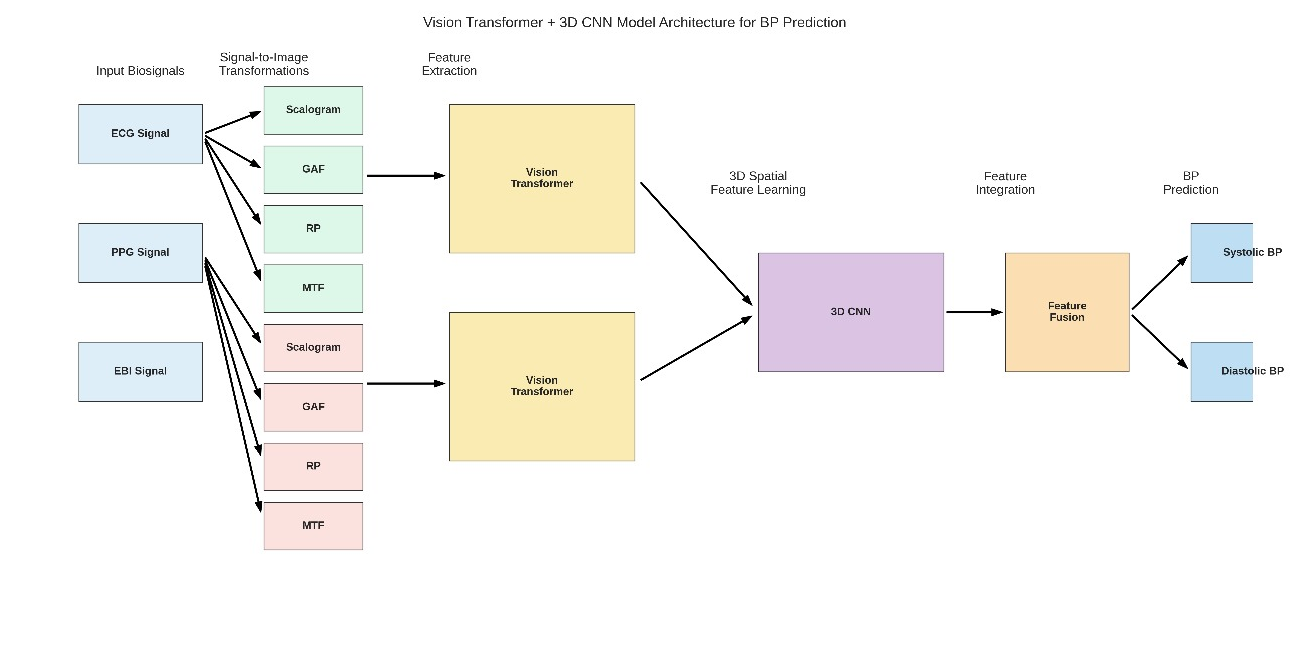

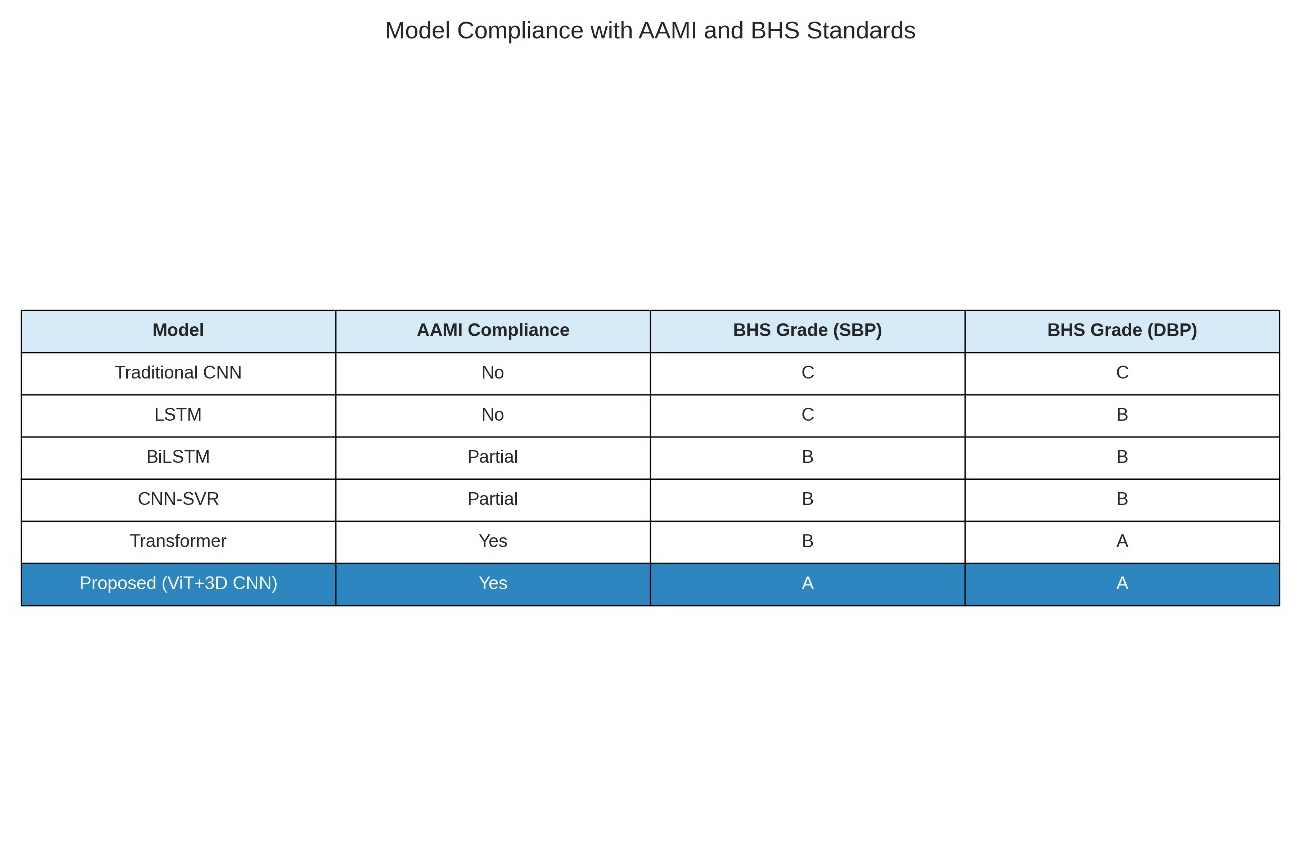

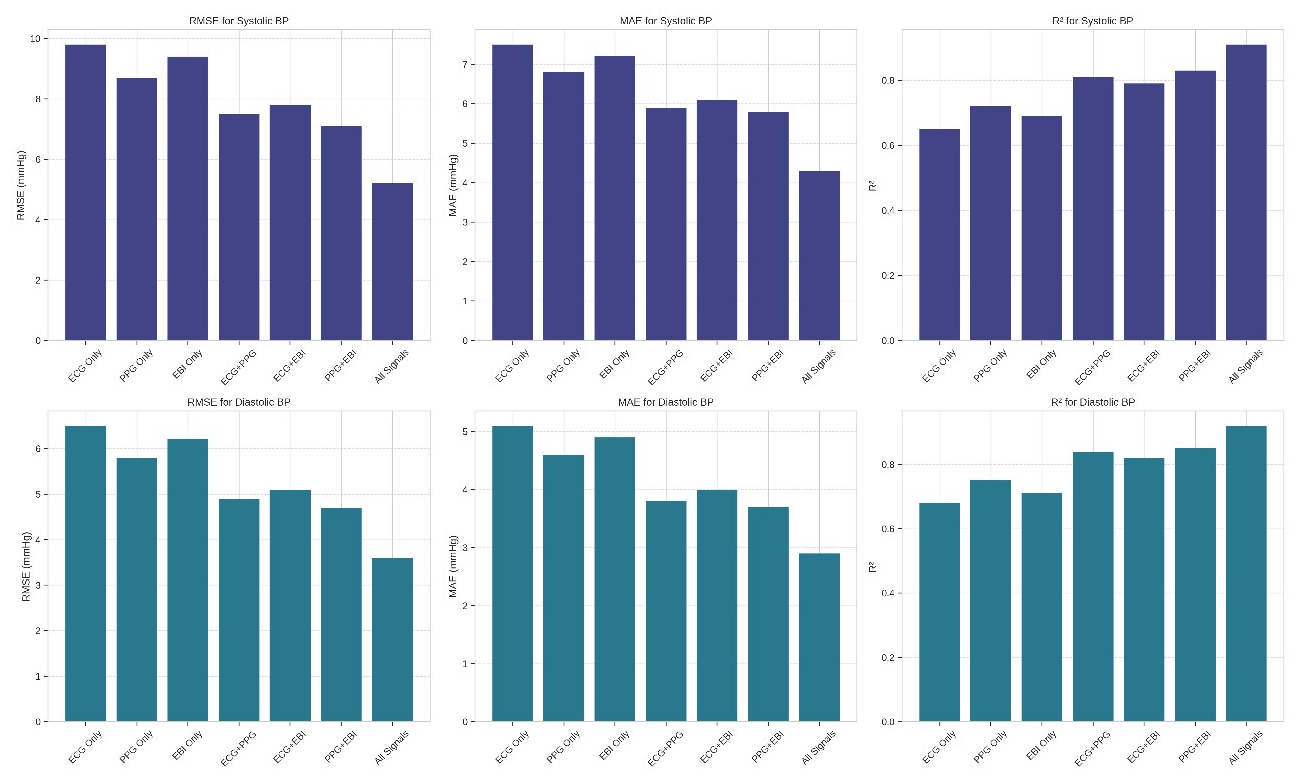

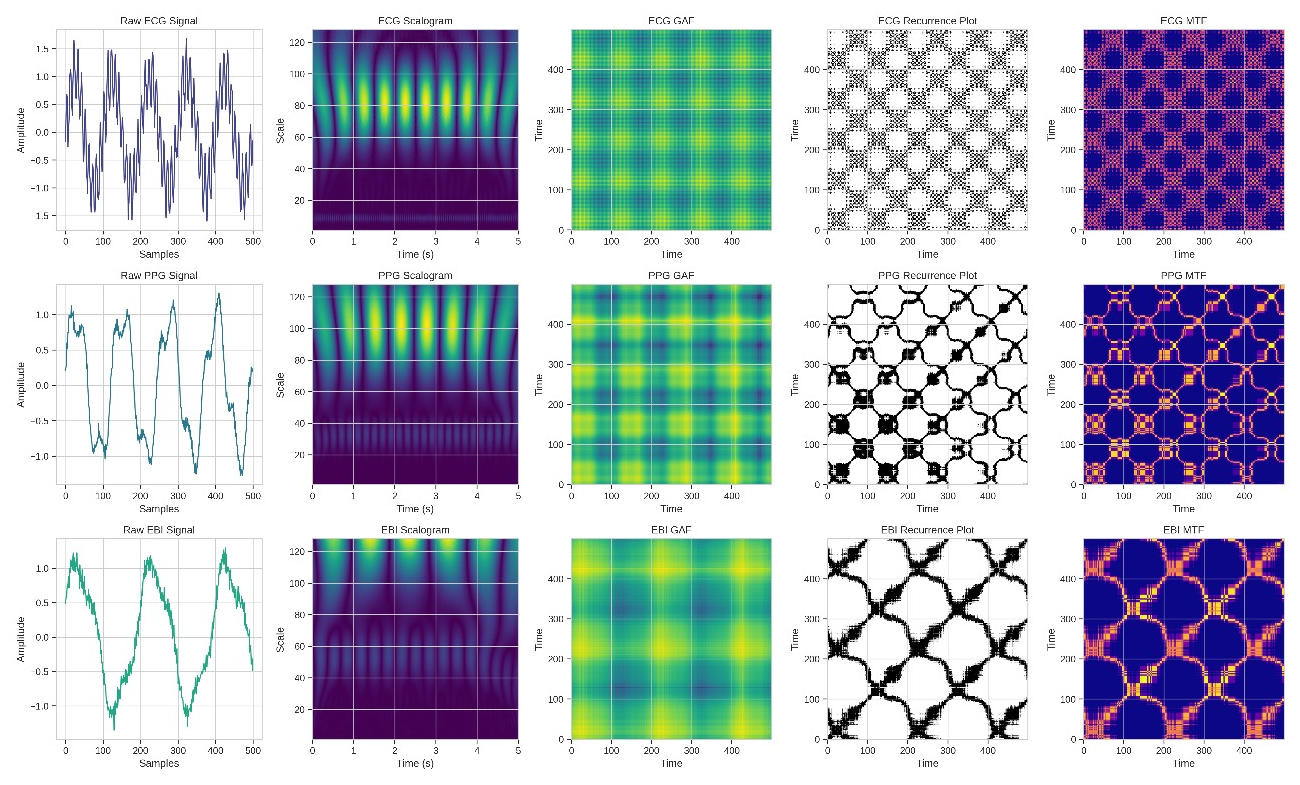

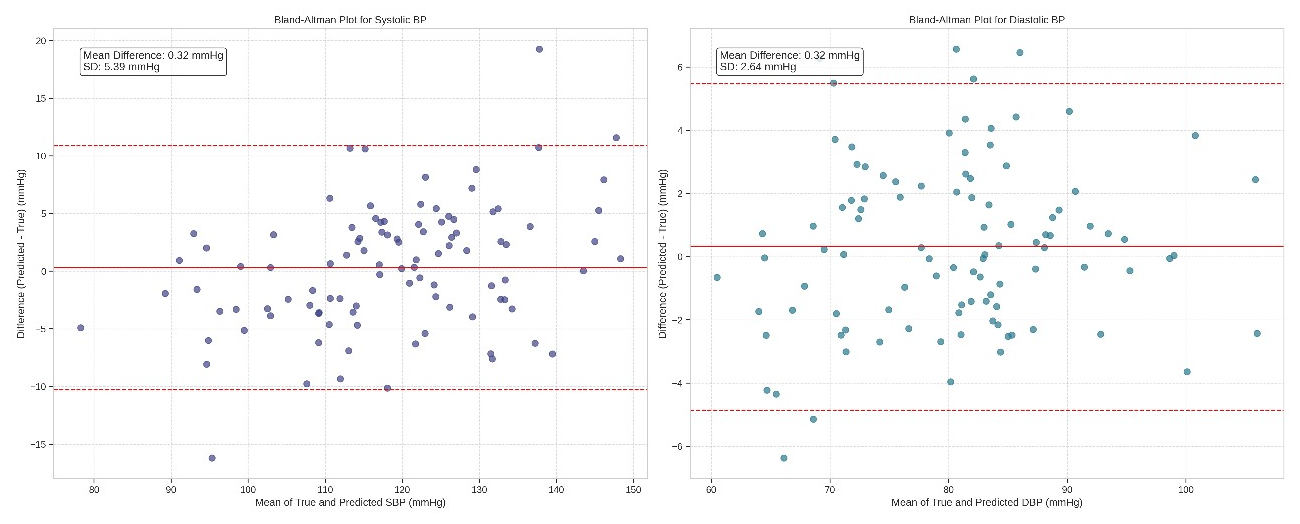

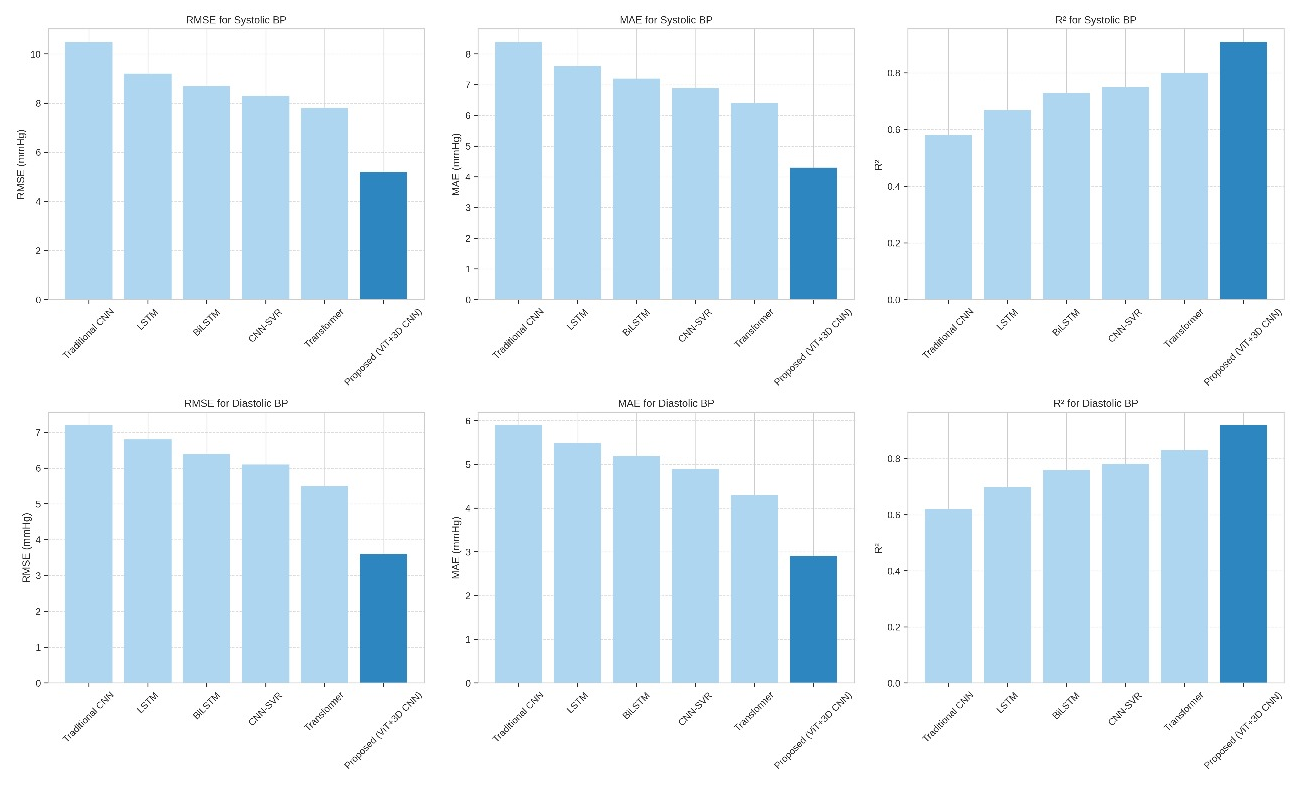

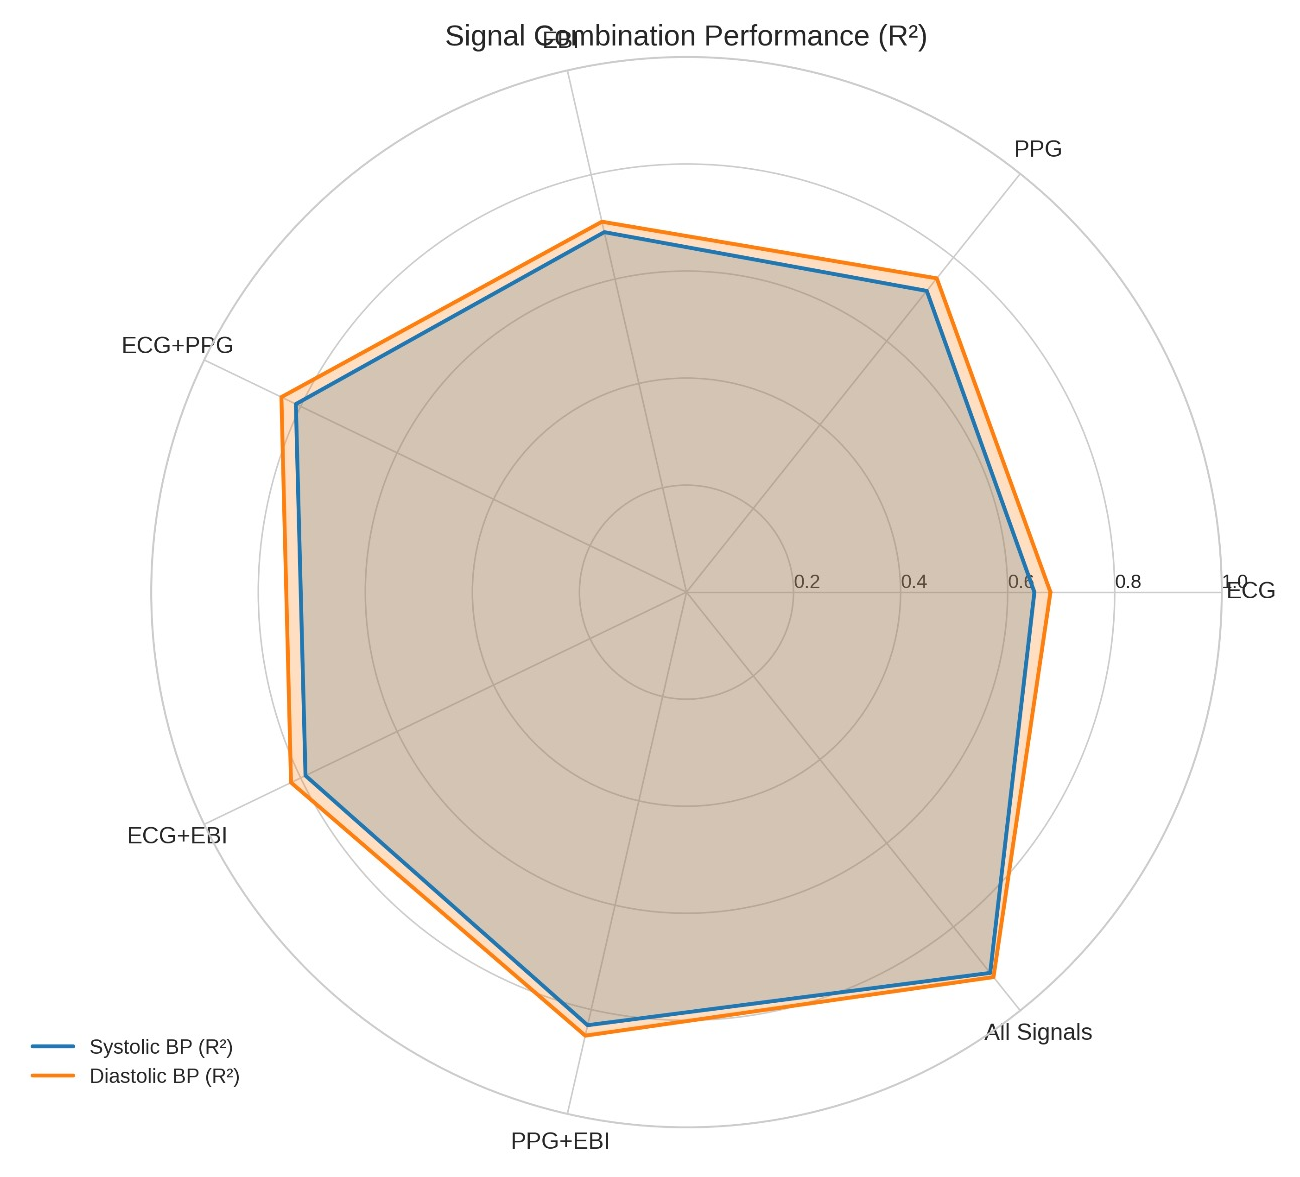

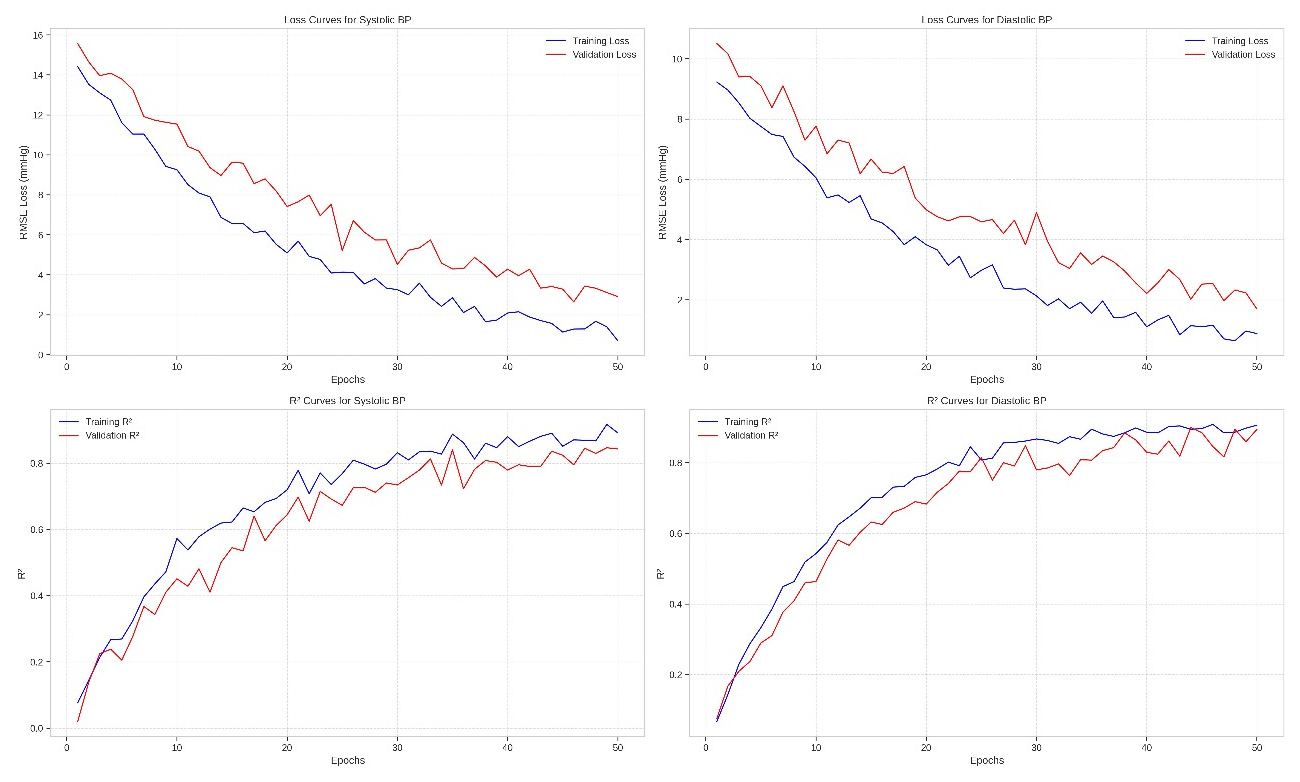

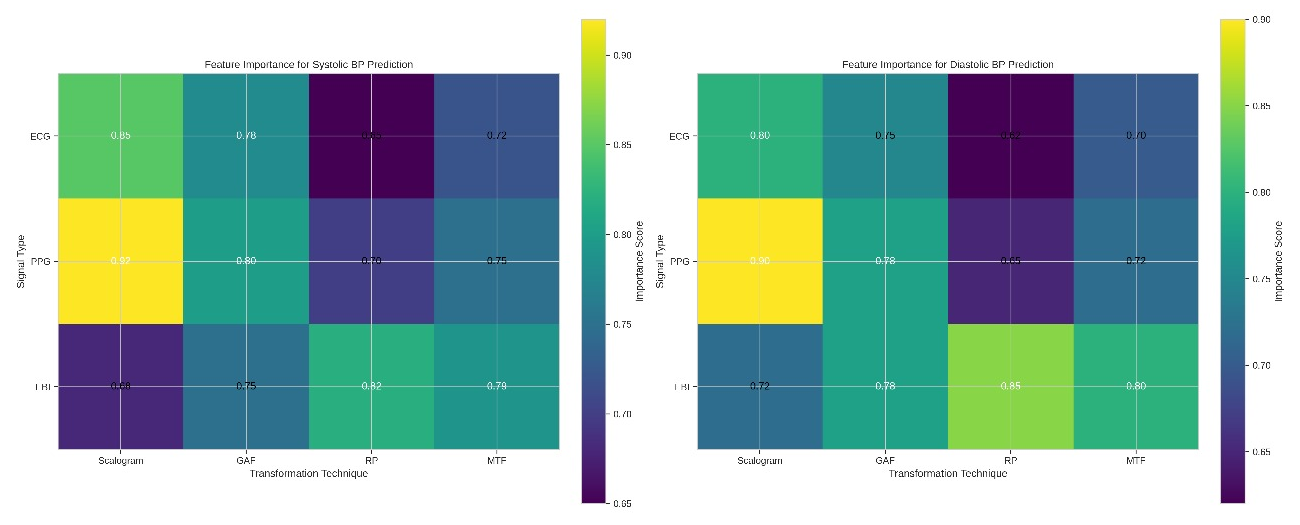

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

folder_path = "results"
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    img = Image.open(image_path)
    dpi = 100 
    width, height = img.size
    plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  
    plt.show()